In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import datetime as dt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import attention
import transformers
import torch

import helper
from helper import *

In [2]:
df = load_and_preprocess()
df = df.reset_index(drop = True)

In [3]:
cutoff = math.floor(0.75*len(df)) #train/test cutoff

#### Just Using Date/Previous Hour Temp.

In [4]:
df.head()

,datetime,Description,Humidity,Wind Direction,Temperature,Pressure,Wind Speed,clouds,rain,mist,snow,shower,thunderstorm,fog,other,Intensity
0,2012-10-01 13:00:00,heavy clouds,93.0,1001.0,285.830000,230.0,4.0,1,0,0,0,0,0,0,0,3.0
1,2012-10-01 14:00:00,sky is clear,91.0,986.0,285.834650,230.0,4.0,0,0,0,0,0,0,0,0,0.0
2,2012-10-01 15:00:00,sky is clear,87.0,945.0,285.847790,231.0,4.0,0,0,0,0,0,0,0,0,0.0
3,2012-10-01 16:00:00,sky is clear,84.0,904.0,285.860929,233.0,4.0,0,0,0,0,0,0,0,0,0.0
4,2012-10-01 17:00:00,sky is clear,80.0,863.0,285.874069,234.0,3.0,0,0,0,0,0,0,0,0,0.0


In [5]:
train = df[:cutoff].reset_index(drop = True)
train = train.iloc[:, 4:5].values
test = df[cutoff:]
test = test.iloc[:, 4:5].values

In [6]:
sc = StandardScaler()
train_std = sc.fit_transform(train)
test_std = sc.transform(test)

In [7]:
def split(sequence, n_timestamp):
    X, y = [], []
    
    for i in range(len(sequence)):
        end = i + n_timestamp
        if end > len(sequence)-1:
            break
        sequence_x, sequence_y = sequence[i:end], sequence[end]
        X.append(sequence_x)
        y.append(sequence_y)
    return np.array(X), np.array(y)

In [8]:
X_train, y_train = split(sequence = train_std, n_timestamp = 10)
X_test, y_test = split(sequence = test_std, n_timestamp = 10)

In [9]:
print(X_train.shape)
print(X_test.shape)

(33929, 10, 1)
(11303, 10, 1)


In [10]:
print(y_train.shape)
print(y_test.shape)

(33929, 1)
(11303, 1)


In [ ]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.LSTM(units = 50))
model.add(keras.layers.Dense(1))

In [ ]:
model.compile(loss = 'mse', optimizer = 'adam')

In [ ]:
history = model.fit(X_train, y_train, epochs = 3)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_test_inv = sc.inverse_transform(y_test)
y_pred_inv = sc.inverse_transform(y_pred)

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([278, 305])
plt.legend()
plt.show()

In [ ]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))

In [ ]:
math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

#### Trying with multiple predictors

In [ ]:
def split_multiple(sequence, n_timestamp, target):
    X, y = [], []
    
    for i in range(len(sequence)):
        end = i + n_timestamp
        if end > len(sequence)-1:
            break
        sequence_x, sequence_y = sequence[i:end], target[end]
        X.append(sequence_x)
        y.append(sequence_y)
    return np.array(X), np.array(y)

In [ ]:
train = df[:cutoff].reset_index(drop = True)
target_train = train[['Temperature']].values
train = train.drop(['datetime', 'Description'], axis = 1).values

test = df[:cutoff].reset_index(drop = True)
target_test = test[['Temperature']].values
test = test.drop(['datetime', 'Description'], axis = 1).values

In [ ]:
sc = StandardScaler()
sc2 = StandardScaler()
train_std = sc.fit_transform(train)
target_train_std = sc2.fit_transform(target_train)
test_std = sc.transform(test)
target_test_std = sc2.transform(target_test)

In [ ]:
X_train, y_train = split_multiple(train_std, 10, target_train_std)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.LSTM(units = 50))
model.add(keras.layers.Dense(1))

In [ ]:
model.compile(loss = 'mse', optimizer = 'adam')

In [ ]:
history = model.fit(X_train, y_train, epochs = 3)

In [ ]:
X_test, y_test = split_multiple(test_std, 10, target_test_std)

In [ ]:
y_pred = model.predict(X_test)

y_test_inv = sc2.inverse_transform(y_test)
y_pred_inv = sc2.inverse_transform(y_pred)

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([270, 295])
plt.legend()
plt.show()

In [ ]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))

In [ ]:
math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

### Incorporating Engineered Features

In [ ]:
df = feature_engineer_important(load_and_preprocess())

In [ ]:
df.iloc[167:170, ] #looks like due to the shifts we should drop the first week of observations (which is fine)

In [ ]:
df = df.dropna()

#### RNN with New Features

In [ ]:
train = df[:cutoff].reset_index(drop = True)
target_train = train[['Temperature']].values
train = train.values

test = df[:cutoff].reset_index(drop = True)
target_test = test[['Temperature']].values
test = test.values

In [ ]:
sc = StandardScaler()
sc2 = StandardScaler()
train_std = sc.fit_transform(train)
target_train_std = sc2.fit_transform(target_train)
test_std = sc.transform(test)
target_test_std = sc2.transform(target_test)

In [ ]:
X_train, y_train = split_multiple(train_std, 10, target_train_std)

In [ ]:
X_train.shape

In [ ]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.LSTM(units = 50))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

In [ ]:
history = model.fit(X_train, y_train, epochs=3)

In [ ]:
X_test, y_test = split_multiple(test_std, 10, target_test_std)

In [ ]:
y_pred = model.predict(X_test)

y_pred_inv = sc2.inverse_transform(y_pred)
y_test_inv = sc2.inverse_transform(y_test)

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([270, 295])
plt.legend()
plt.show()

In [ ]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))

### Transformers

#### Attention Model

In [2]:
df = feature_engineer_important(load_and_preprocess())
df = df.dropna()

/Users/jakehogan/Desktop/MMA Courses/INSY 695/Assignments/Group Project/Cloud-Computations/helper.py:139: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week'] = df['datetime'].dt.weekofyear


In [3]:
cutoff = math.floor(0.75*len(df)) #train/test cutoff
df.head()

,Humidity,Wind Direction,Pressure,Wind Speed,hour,lag1,lag2,lag12,lag30,max daily temp,...,min daily pressure,min weekly temp,mean weekly hum,mean weekly wind direction,rolling_mean_temp,rolling_mean_pressure,rolling_mean_wind_dir,rolling_mean_wind_speed,rolling_mean_humidity,Temperature
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-09 19:00:00,71.861538,1016.424953,203.0,4.0,19,284.82,283.56,278.42,278.63,283.52,...,282.16,282.16,78.779569,1015.584173,285.599704,198.071006,1015.863284,1.656805,77.294310,284.97
2012-10-09 20:00:00,71.861538,1016.424953,242.0,2.0,20,284.97,284.82,277.22,279.57,283.52,...,282.16,282.16,78.779569,1015.584173,285.599588,198.329412,1015.866588,1.658824,77.262353,285.58
2012-10-09 21:00:00,71.861538,1016.424953,205.0,0.0,21,285.58,284.97,276.02,280.78,283.52,...,282.16,282.16,78.779569,1015.584173,285.600468,198.368421,1015.869853,1.649123,77.230769,285.75
2012-10-09 22:00:00,71.861538,1016.424953,217.0,0.0,22,285.75,285.58,274.95,282.35,283.52,...,282.16,282.16,78.779569,1015.584173,285.597209,198.476744,1015.873080,1.639535,77.199552,285.04
2012-10-09 23:00:00,43.000000,1024.000000,190.0,2.0,23,285.04,285.75,274.61,282.37,283.52,...,282.16,282.16,78.779569,1015.584173,285.574855,198.427746,1015.920057,1.641618,77.001867,281.73


In [4]:
train = df[:cutoff].reset_index(drop = True)
target_train = train[['Temperature']].values
train = train.values

test = df[:cutoff].reset_index(drop = True)
target_test = test[['Temperature']].values
test = test.values

In [5]:
sc = StandardScaler()
sc2 = StandardScaler()
train_std = sc.fit_transform(train)
target_train_std = sc2.fit_transform(target_train)
test_std = sc.transform(test)
target_test_std = sc2.transform(target_test)

In [6]:
X_train, y_train = split_multiple(train_std, 24, target_train_std)
X_test, y_test = split_multiple(test_std, 24, target_test_std)
X_train.shape

(33766, 24, 21)

In [14]:
model_input = keras.Input(shape = X_train.shape[1:])
x = keras.layers.LSTM(50, return_sequences = True)(model_input)
x = keras.layers.LSTM(50, return_sequences = True)(x)
x = attention.Attention()(x)
model_output = keras.layers.Dense(1)(x)
model = keras.models.Model(model_input, model_output)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 24, 21)]     0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 24, 50)       14400       input_4[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 24, 50)       20200       lstm_4[0][0]                     
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 50)           0           lstm_5[0][0]                     
____________________________________________________________________________________________

In [15]:
history = model.fit(X_train, y_train, epochs = 3)

Epoch 1/3
1056/1056 [==============================] - 15s 12ms/step - loss: 0.0647
Epoch 2/3
1056/1056 [==============================] - 12s 11ms/step - loss: 0.0116
Epoch 3/3
1056/1056 [==============================] - 11s 11ms/step - loss: 0.0089


In [16]:
y_pred = model.predict(X_test)

y_pred_inv = sc2.inverse_transform(y_pred)
y_test_inv = sc2.inverse_transform(y_test)

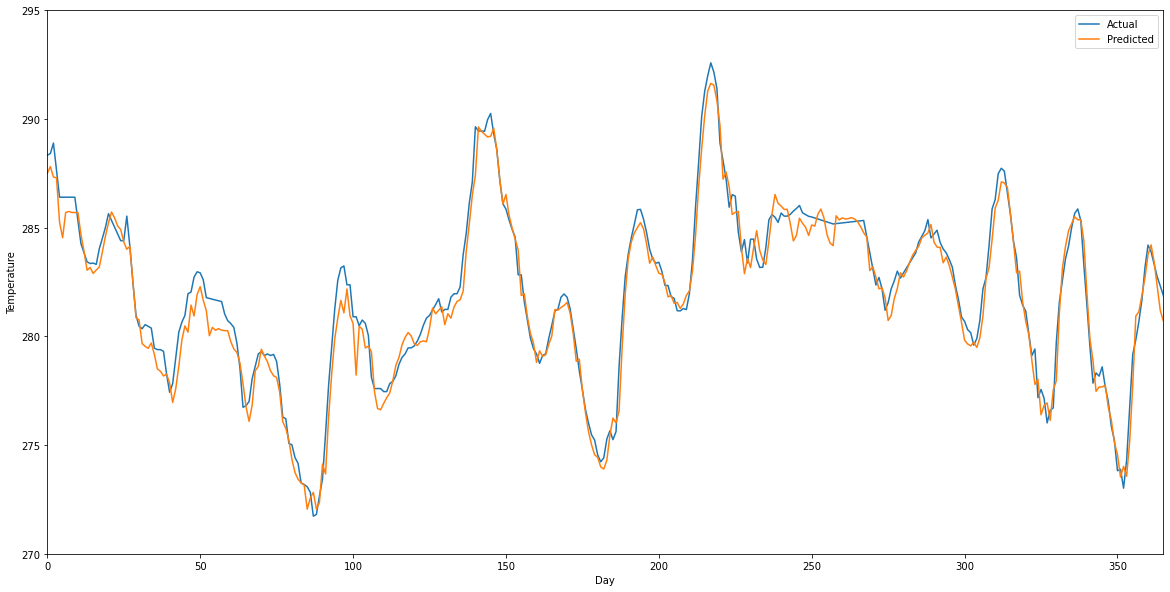

In [17]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([270, 295])
plt.legend()
plt.show()

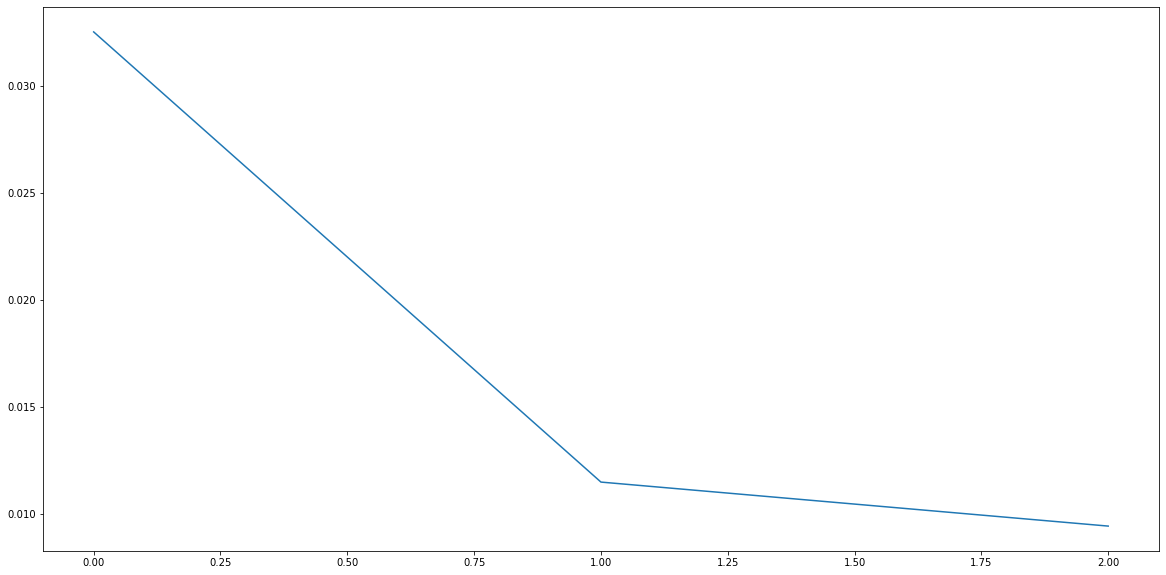

In [19]:
plt.figure(figsize = (20, 10))
plt.plot(history.history['loss'])
plt.show()

In [18]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))

MSE: 1.651484897076956
R-Squared: 0.9890336822704596
RMSE: 1.2851011232883411


----

#### Multi-Head Attention Model

In [3]:
df = feature_engineer(load_and_preprocess())
df = df.dropna()
df.head()

/Users/jakehogan/Desktop/MMA Courses/INSY 695/Assignments/Group Project/Cloud-Computations/helper.py:139: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week'] = df['datetime'].dt.weekofyear


,Description,Humidity,Wind Direction,Temperature,Pressure,Wind Speed,clouds,rain,mist,snow,...,rolling_min_temp,rolling_min_pressure,rolling_min_wind_dir,rolling_min_wind_speed,rolling_min_humidity,rolling_max_temp,rolling_max_pressure,rolling_max_wind_dir,rolling_max_wind_speed,rolling_max_humidity
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-09 19:00:00,sky is clear,71.861538,1016.424953,284.97,203.0,4.0,0,0,0,0,...,274.61,0.0,1007.0,0.0,24.0,293.63,360.0,1022.0,7.0,100.0
2012-10-09 20:00:00,sky is clear,71.861538,1016.424953,285.58,242.0,2.0,0,0,0,0,...,274.61,0.0,1007.0,0.0,24.0,293.63,360.0,1022.0,7.0,100.0
2012-10-09 21:00:00,sky is clear,71.861538,1016.424953,285.75,205.0,0.0,0,0,0,0,...,274.61,0.0,1007.0,0.0,24.0,293.63,360.0,1022.0,7.0,100.0
2012-10-09 22:00:00,sky is clear,71.861538,1016.424953,285.04,217.0,0.0,0,0,0,0,...,274.61,0.0,1007.0,0.0,24.0,293.63,360.0,1022.0,7.0,100.0
2012-10-09 23:00:00,moderate clouds,43.000000,1024.000000,281.73,190.0,2.0,1,0,0,0,...,274.61,0.0,1007.0,0.0,24.0,293.63,360.0,1024.0,7.0,100.0


In [28]:
cutoff = math.floor(0.75*len(df)) #train/test cutoff

In [30]:
df = df[['Humidity', 'Wind Direction', 'Temperature', 'Pressure', 'Wind Speed']]

In [31]:
train = df[:cutoff].reset_index(drop = True)
target_train = train[['Temperature']].values
train = train.values

test = df[:cutoff].reset_index(drop = True)
target_test = test[['Temperature']].values
test = test.values

In [32]:
sc = StandardScaler()
sc2 = StandardScaler()
train_std = sc.fit_transform(train)
target_train_std = sc2.fit_transform(target_train)
test_std = sc.transform(test)
target_test_std = sc2.transform(target_test)

In [63]:
# https://www.kaggle.com/shujian/transformer-with-lstm

import random, os, sys
import numpy as np
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *
import tensorflow as tf
from keras.engine.topology import Layer
import keras.backend as K

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass


embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

class Transformer():
    def __init__(self, len_limit, embedding_matrix, d_model=embed_size, \
              d_inner_hid=512, n_head=10, d_k=64, d_v=64, layers=2, dropout=0.1, \
              share_word_emb=False, **kwargs):
        self.name = 'Transformer'
        self.len_limit = len_limit
        self.src_loc_info = False # True # sl: fix later
        self.d_model = d_model
        self.decode_model = None
        d_emb = d_model

        pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                            weights=[GetPosEncodingMatrix(len_limit, d_emb)])

        i_word_emb = Embedding(max_features, d_emb, weights=[embedding_matrix]) # Add Kaggle provided embedding here

        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                               word_emb=i_word_emb, pos_emb=pos_emb)

        
    def get_pos_seq(self, x):
        mask = K.cast(K.not_equal(x, 0), 'int32')
        pos = K.cumsum(K.ones_like(x, 'int32'), 1)
        return pos * mask

    def compile(self, active_layers=999):
        src_seq_input = Input(shape=(None, ))
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(src_seq_input)
        
        # LSTM before attention layers
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
        x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])
        conc = Dense(64, activation="relu")(conc)
        x = Dense(2, activation="softmax")(conc)   
        
        
        self.model = Model(inputs=src_seq_input, outputs=x)
        self.model.compile(optimizer = 'Adamax', loss = 'binary_crossentropy', metrics=['accuracy'])

In [64]:
X_train.shape

(33766, 24, 5)

In [65]:
model_input = keras.Input(shape = X_train.shape[1:])

x = keras.layers.Bidirectional(LSTM(128, return_sequences=True))(model_input)
x = keras.layers.Bidirectional(LSTM(64, return_sequences=True))(x)

x, self_attn = MultiHeadAttention(n_head = 3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
conc = Dense(64, activation='sigmoid')(conc)
model_output = Dense(1)(conc)

model = keras.models.Model(model_input, model_output)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 24, 5)]      0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 24, 256)      137216      input_17[0][0]                   
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 24, 128)      164352      bidirectional_2[0][0]            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 24, 192)      24576       bidirectional_3[0][0]            
____________________________________________________________________________________________

In [66]:
history = model.fit(X_train, y_train, epochs = 3)

Epoch 1/3
1056/1056 [==============================] - 48s 42ms/step - loss: 0.1090
Epoch 2/3
1056/1056 [==============================] - 43s 41ms/step - loss: 0.0172
Epoch 3/3
1056/1056 [==============================] - 40s 38ms/step - loss: 0.0151


In [68]:
y_pred = model.predict(X_test)

y_pred_inv = sc2.inverse_transform(y_pred)
y_test_inv = sc2.inverse_transform(y_test)

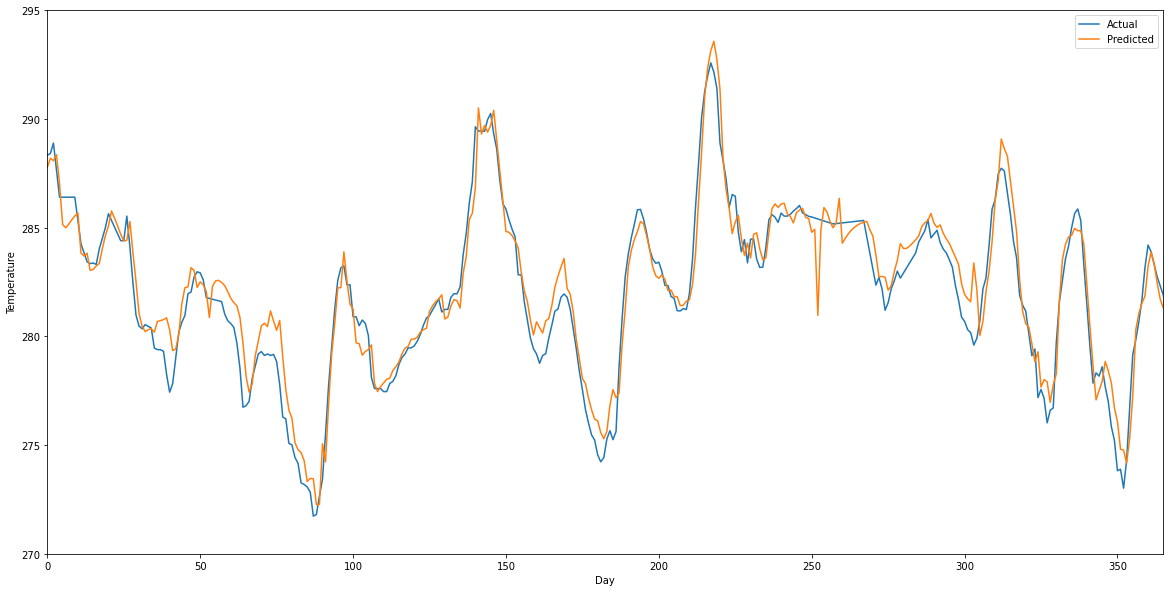

In [69]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([270, 295])
plt.legend()
plt.show()

In [70]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))

MSE: 3.6622930175532713
R-Squared: 0.9756813586849925
RMSE: 1.9137118428732345
